In [1]:
!pip install mplfinance

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join("/home/ubuntu/projects/hindsight/examples/data/ast", '../../..')))

import matplotlib.pyplot as plt
import mplfinance as mpf
import jax

# Data Management imports
from src import DataManager
from src.data.ast.manager import FormulaManager
from src.data.ast.functions import register_built_in_functions, get_function_context
from src.data.core import prepare_for_jit

# Backtester imports
from src.backtester.core import EventBasedStrategy, BacktestEngine

/home/ubuntu/projects/hindsight/src/data/core/struct.py:316: AccessorRegistrationWarning: registration of accessor <class 'src.data.core.struct.DataArrayDateTimeAccessor'> under name 'dt' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor('dt')


In [3]:
# Setup core
data_manager = DataManager()

In [4]:
# Load crypto USDT data
market_data = data_manager.load_builtin(
                    "crypto_standard", 
                    "2019-01-01", 
                    "2024-01-01")['crypto_prices'] # Load USDT Spot data from 2019 to 2024 at HOURLY timeframe

crypto/spot/binance: Attemping to load found cache(/home/suchismit/data/cache/crypto/spot/binance/356721556fd65971ff4fd6398f995462_2019-01-01_2024-12-31.nc).
crypto/spot/binance: Successfully loaded from /home/suchismit/data/cache/crypto/spot/binance/356721556fd65971ff4fd6398f995462_2019-01-01_2024-12-31.nc


In [5]:
market_data

<xarray.Dataset> Size: 299MB
Dimensions:       (year: 6, month: 12, day: 31, hour: 24, asset: 265,
                   time_flat: 53568)
Coordinates:
  * year          (year) int32 24B 2019 2020 2021 2022 2023 2024
  * month         (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * day           (day) int32 124B 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
  * hour          (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * asset         (asset) <U13 14kB '1000BONKUSDT' '1000BTTCUSDT' ... 'ZRXUSDT'
    time          (year, month, day, hour) datetime64[ns] 429kB 2019-01-01 .....
  * time_flat     (time_flat) int64 429kB 0 1 2 3 4 ... 53564 53565 53566 53567
    mask          (time_flat, asset) bool 14MB False False False ... False False
    mask_indices  (time_flat) int64 429kB 8905 8906 8907 8908 ... -1 -1 -1 -1
Data variables:
    open          (year, month, day, hour, asset) float32 57MB nan nan ... nan
    high          (year, month, day, hour, asset) float32 57MB nan nan ... nan
    low           (year, month, day, hour, asset) float32 57MB nan nan ... nan
    close         (year, month, day, hour, asset) float32 57MB nan nan ... nan
    volume        (year, month, day, hour, asset) float32 57MB nan nan ... nan

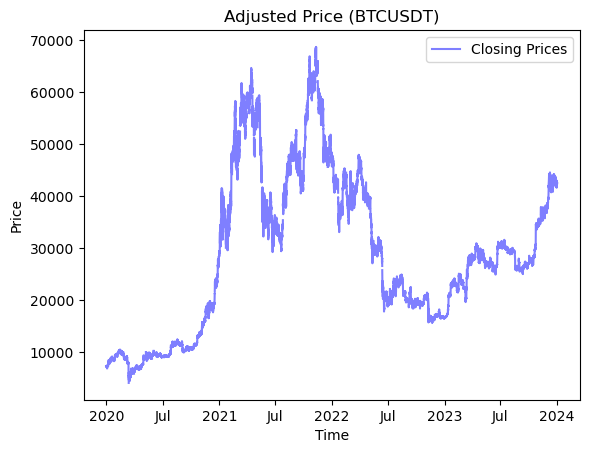

In [20]:
# Let's see BTC/USDT spot closing prices, highs, and lows
btc = market_data[['close']].sel(asset='BTCUSDT') 
btc = btc.dt.to_time_indexed()

btc['close'].plot.line(x="time", label='Closing Prices', color='blue', alpha=0.5) 
plt.title(f"Adjusted Price (BTCUSDT)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [7]:
# Compute some characteristics 
# MA for different periods

# Create a closure that captures the static context
def create_jit_evaluator():
    function_context = get_function_context()
    manager = FormulaManager()

    # Capture the static context in the closure
    static_context = {
        "price": "close",
        **function_context
    }
    
    # JIT compile only the dataset processing part
    @jax.jit
    def evaluate_formulas_jit(dataset):
        # Reconstruct the full context inside the JIT function
        context = {
            "_dataset": dataset,
            **static_context
        }
        
        # Multi-configuration evaluation with lag examples
        formula_configs = {
            "hma": [
                {"window": 100},
                {"window": 200}
            ],
        }
        
        return manager.evaluate_bulk(formula_configs, context)
    
    return evaluate_formulas_jit

# Prepare data for JIT, since some vars are not JIT compatible. For example, strings.
market_data_jit, recover = prepare_for_jit(market_data)

evaluate_formulas_jit = create_jit_evaluator()
results = evaluate_formulas_jit(market_data_jit)

results

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<xarray.Dataset> Size: 186MB
Dimensions:       (hour: 24, time_flat: 53568, year: 6, asset: 265, month: 12,
                   day: 31)
Coordinates:
  * hour          (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * time_flat     (time_flat) int64 429kB 0 1 2 3 4 ... 53564 53565 53566 53567
  * year          (year) int32 24B 2019 2020 2021 2022 2023 2024
    mask          (time_flat, asset) bool 14MB False False False ... False False
  * asset         (asset) <U13 14kB '1000BONKUSDT' '1000BTTCUSDT' ... 'ZRXUSDT'
  * month         (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
    mask_indices  (time_flat) int64 429kB 8905 8906 8907 8908 ... -1 -1 -1 -1
  * day           (day) int32 124B 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
    time          (year, month, day, hour) datetime64[ns] 429kB 2019-01-01 .....
Data variables:
    hma_ww100     (asset, year, month, day, hour) float32 57MB ...
    hma_ww200     (asset, year, month, day, hour) float32 57MB ...
    wma           (asset, year, month, day, hour) float32 57MB ...

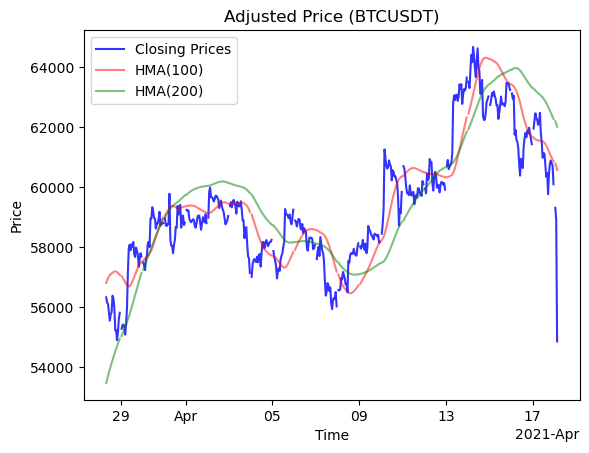

In [27]:
# Let's see BTC/USDT spot closing prices, highs, and lows
indices = slice(20_000, 20_500)

hmas = results[['hma_ww100', 'hma_ww200']].sel(asset='BTCUSDT') 
hmas = hmas.dt.to_time_indexed().isel(time=indices)

btc.isel(time=indices)['close'].plot.line(x="time", label='Closing Prices', color='blue', alpha=0.8) 
hmas['hma_ww100'].plot.line(x="time", label='HMA(100)', color='red', alpha=0.5)
hmas['hma_ww200'].plot.line(x="time", label='HMA(200)', color='green', alpha=0.5) 
plt.title(f"Adjusted Price (BTCUSDT)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)